In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
import os
import seaborn as sns

2023-04-02 16:36:07.011643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Resize images
SIZE = 128
output_dir = f'./{SIZE}'
for file in glob.glob('./Thresholded/*'):
	filename = file.split('/')[-1]
	img = cv2.imread(file, cv2.IMREAD_COLOR)
	img = cv2.resize(img, (SIZE,SIZE))
	cv2.imwrite(os.path.join(output_dir, filename), img)

In [11]:

SIZE = 128
images = []
labels = []

for file in glob.glob(f'./{SIZE}/*'):
	filename = file.split('/')[-1]
	if filename[-5] == '0':
		labels.append(0)
	else:
		labels.append(1)
	img = cv2.imread(file, cv2.IMREAD_COLOR)
	img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
	images.append(img)

images = np.array(images)
labels = np.array(labels)

In [29]:
#  Get two arrays with positive and negative images
pos_im = [images[i,:,:,:] for i in range(images.shape[0]) if labels[i]]
pos_im = np.array(pos_im)
neg_im = [images[i,:,:,:] for i in range(images.shape[0]) if not labels[i]]
neg_im = np.array(neg_im)
num_pos = pos_im.shape[0]
num_neg = neg_im.shape[0]
print(f'There are {num_pos} images with bacteria and {num_neg} without')


There are 355 images with bacteria and 3997 without


In [31]:
#  There are ~10x positive than negative.
#  For initital training let's get all positive and equal number of negative
#  For that:
#  (1) Index of randomly selected negative images
np.random.seed(0) # For reproducibility
idx = np.random.choice(np.arange(neg_im.shape[0]), num_pos, replace = False)
#  (2) Apply this index to the array of images
neg_selected = neg_im[idx, :, :, :]
#  (3) Make a full dataset, with X and y, not split into train.test yet
X = np.concatenate((pos_im,neg_selected), axis =0)
y = np.concatenate((np.ones(num_pos), np.zeros(neg_selected.shape[0])))
print(X.shape, y.shape)

(710, 128, 128, 3) (710,)


In [34]:
# Now shuffle the dataset and split it into 7/3 tran/test sets
num_datapoints = X.shape[0]
indices = np.arange(num_datapoints)
shuffled_indices = np.random.permutation(indices)

# Re-order training examples and corresponding labels using the randomly
# shuffled indices.
X_shuffled = X[shuffled_indices, :, :, :]
y_shuffled = y[shuffled_indices]

num_train = int(num_datapoints*0.7)
num_test = num_datapoints - num_train

x_train = X_shuffled[ :num_train, : , : , : ]
y_train = y_shuffled[ :num_train]
x_test = X_shuffled[num_train: , : , : , : ]
y_test = y_shuffled[num_train: ]

print(f'Set shape: train-> {x_train.shape}, test ->{x_test.shape}')

Set shape: train-> (496, 128, 128, 3), test ->(214, 128, 128, 3)


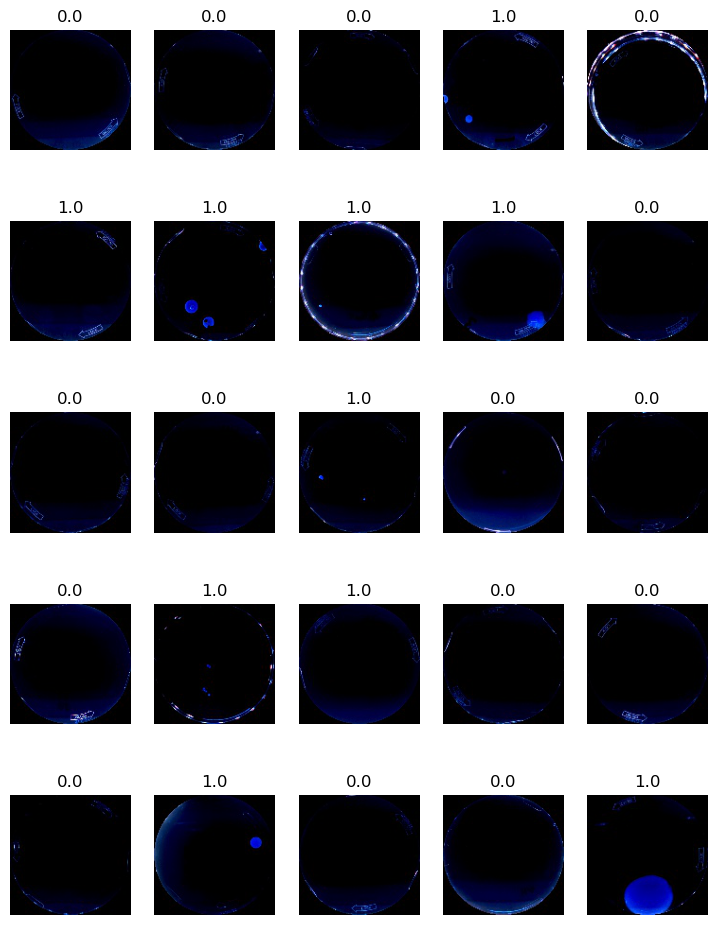

In [48]:
# Visualize first 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(9,12))

row = 0
label_name = "Shirt predicted as coat"
axs[row,0].set_title(label_name)
axs[row,0].axis('off')

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = 5*i+j
    image = cv2.cvtColor(x_train[idx], cv2.COLOR_HSV2RGB)
    axs[i,j].imshow(image)
    axs[i,j].set_title(y_train[idx])
    axs[i,j].axis('off')

plt.show()


In [49]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [50]:
activation = 'sigmoid'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(batch_normalization.BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(batch_normalization.BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(batch_normalization.BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(batch_normalization.BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

2023-04-02 18:12:28.017833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 18:12:28.018974: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [51]:
#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(2, activation = 'softmax')(x)

# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0     

In [52]:

history = cnn_model.fit(x_train, y_train_one_hot, epochs=50, validation_data = (x_test, y_test_one_hot))

Epoch 1/50
16/16 [==============================] - 56s 3s/step - loss: 0.9562 - accuracy: 0.5565 - val_loss: 1.4173 - val_accuracy: 0.4626
Epoch 2/50
16/16 [==============================] - 55s 3s/step - loss: 0.6824 - accuracy: 0.5948 - val_loss: 1.4687 - val_accuracy: 0.4626
Epoch 3/50
16/16 [==============================] - 55s 3s/step - loss: 0.6598 - accuracy: 0.6310 - val_loss: 1.2868 - val_accuracy: 0.4626
Epoch 4/50
16/16 [==============================] - 56s 3s/step - loss: 0.6620 - accuracy: 0.6250 - val_loss: 1.1267 - val_accuracy: 0.4626
Epoch 5/50
16/16 [==============================] - 55s 3s/step - loss: 0.6846 - accuracy: 0.5665 - val_loss: 1.1116 - val_accuracy: 0.4626
Epoch 6/50
16/16 [==============================] - 55s 3s/step - loss: 0.7278 - accuracy: 0.5141 - val_loss: 0.8347 - val_accuracy: 0.4626
Epoch 7/50
16/16 [==============================] - 55s 3s/step - loss: 0.7084 - accuracy: 0.5282 - val_loss: 0.8128 - val_accuracy: 0.4626
Epoch 8/50
16/16 [==

In [54]:
cnn_model.save('./128')

INFO:tensorflow:Assets written to: ./128/assets


INFO:tensorflow:Assets written to: ./128/assets


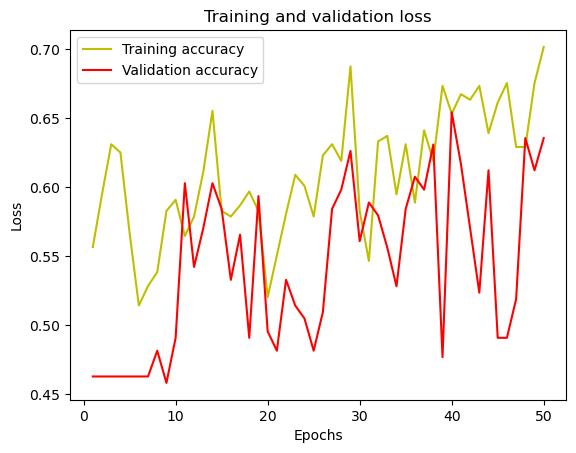

In [53]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

7/7 [==============================] - 9s 1s/step
[[82 33]
 [45 54]]


<AxesSubplot: >

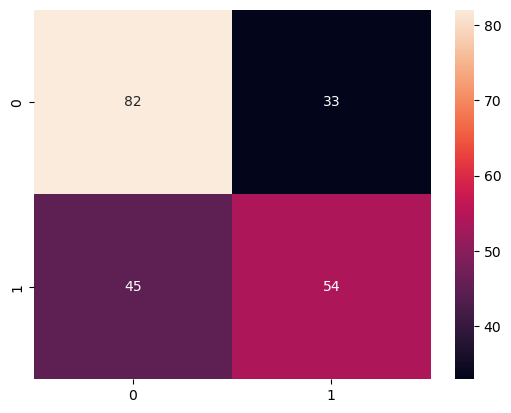

In [55]:
prediction_NN = cnn_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction_NN)
print(cm)
sns.heatmap(cm, annot=True)

In [56]:
#Now, let us use features from convolutional network for RF
X_for_RF = feature_extractor.predict(x_train) #This is out X input to RF

16/16 [==============================] - 18s 1s/step


In [57]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))

7/7 [==============================] - 8s 1s/step
Accuracy =  0.6728971962616822


<AxesSubplot: >

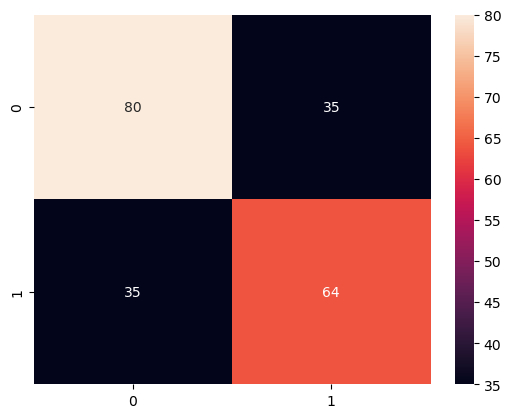

In [58]:
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(y_test, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

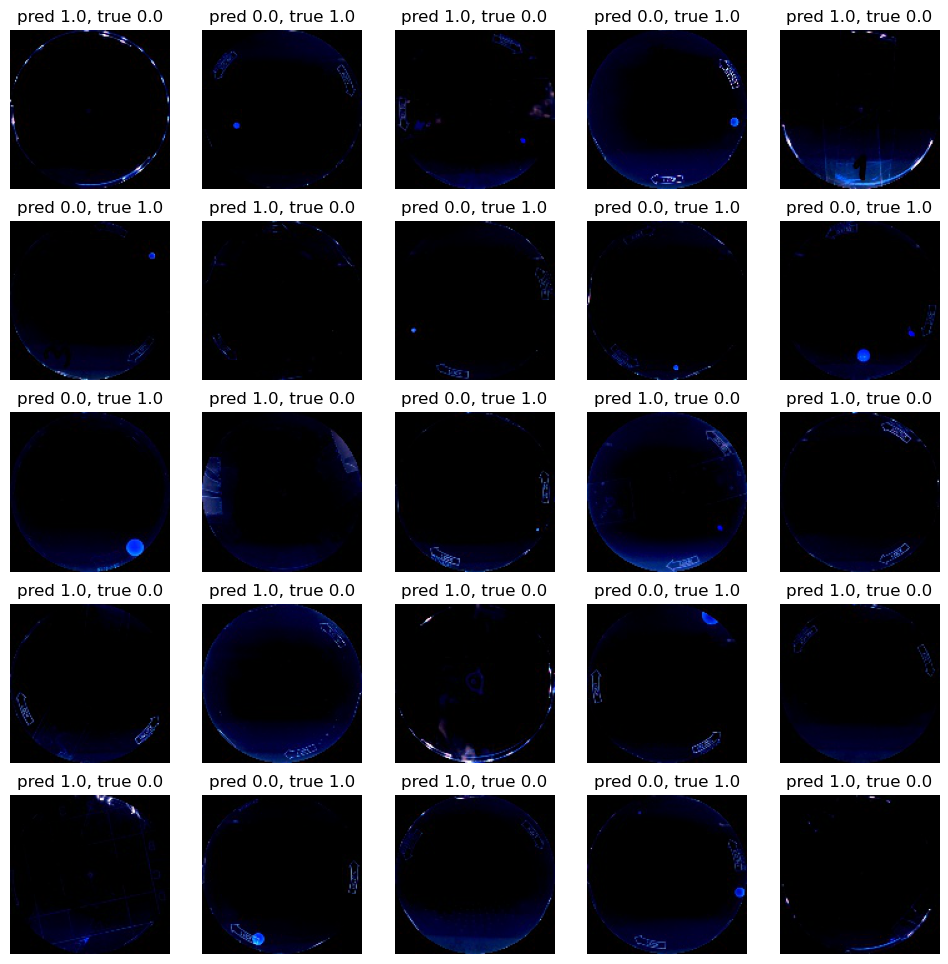

In [63]:
# Visualize 25 mistakes
error_idx = [i for i, rslt in enumerate(y_test) if (rslt + prediction_RF[i] == 1)]

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = error_idx[5*i+j]
    image = cv2.cvtColor(x_test[idx], cv2.COLOR_HSV2RGB)
    axs[i,j].imshow(image)
    axs[i,j].set_title(f'pred {prediction_RF[idx]}, true {y_test[idx]}')
    axs[i,j].axis('off')

plt.show()